In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import StepLR
from collections import Counter
import seaborn as sns

C:\Users\yoavl\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_torch_dataset():
    all_data = []
    scaler = MinMaxScaler()
    columns = ['Input Voltage', 'Output Voltage', 'Tachometer']
    num_rows = 122824
    for i in range(1, 561):
        temp_df = pd.read_csv(f'../PHM09_competition_1/Run_{i}.csv', names=columns, nrows=num_rows)
        normalized_data = scaler.fit_transform(temp_df)
        temp_tensor = torch.tensor(normalized_data, dtype=torch.float32)
        temp_tensor = temp_tensor.unsqueeze(dim=0)  
        all_data.append(temp_tensor)
    
    all_data_tensor = torch.stack(all_data, dim=0)
    return all_data_tensor

dataset_tensor = create_torch_dataset()

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1), # Adjusted for 1 input channel
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid() # Assuming the input data is normalized between 0 and 1
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [1]:
%%time
def train_model(model, train_loader, val_loader, hyper_params):
    best_loss = float('inf')
    history = {'train': [], 'val': []}
    epochs_no_improve = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])
    scheduler = StepLR(optimizer, step_size=hyper_params['step_size'], gamma=hyper_params['gamma'])
    loss_fn = getattr(nn, hyper_params['loss_fn'])()

    for epoch in range(1, hyper_params['n_epochs'] + 1):
        model.train()
        train_loss = []
        for seq_true in train_loader:
            optimizer.zero_grad()
            seq_pred = model(seq_true)
            loss = loss_fn(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        scheduler.step()
        model.eval()
        val_loss = []
        with torch.no_grad():
            for seq_true in val_loader:
                seq_pred = model(seq_true)
                loss = loss_fn(seq_pred, seq_true)
                val_loss.append(loss.item())

        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_val_loss = sum(val_loss) / len(val_loss)
        history['train'].append(avg_train_loss)
        history['val'].append(avg_val_loss)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == hyper_params['patience']:
                print(f'Early stopping triggered after {epoch} epochs.')
                break

        print(f'Epoch {epoch}: train loss {avg_train_loss} val loss {avg_val_loss}')
    
    return model, history

# Revised create_date_loader function
def create_date_loader(dataset_tensor, hyper_params):
    dataset_tensor = dataset_tensor.view(560, 1, -1)  # Adjust dimensions as needed
    train_size = int(0.8 * len(dataset_tensor))
    val_size = len(dataset_tensor) - train_size
    train_dataset, val_dataset = random_split(dataset_tensor, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=hyper_params['batch_size'], shuffle=True, num_workers=os.cpu_count())
    val_loader = DataLoader(val_dataset, batch_size=hyper_params['batch_size'], num_workers=os.cpu_count())
    return train_loader, val_loader

# Initialize hyper_params and create dataloaders
hyper_params = {
    'batch_size': 32,
    'n_epochs': 100,
    'loss_fn': 'L1Loss',
    'patience': 50,
    'step_size': 7,
    'lr': 0.01,
    'gamma': 0.1,
}

# Ensure you have dataset_tensor defined before calling this
train_loader, val_loader = create_date_loader(dataset_tensor, hyper_params)

# Train the model
model = Autoencoder()
model, history = train_model(model, train_loader, val_loader, hyper_params)

# Save the trained model
torch.save(model, f"model1_{hyper_params['n_epochs']}.pth")
print("Entire model saved successfully.")

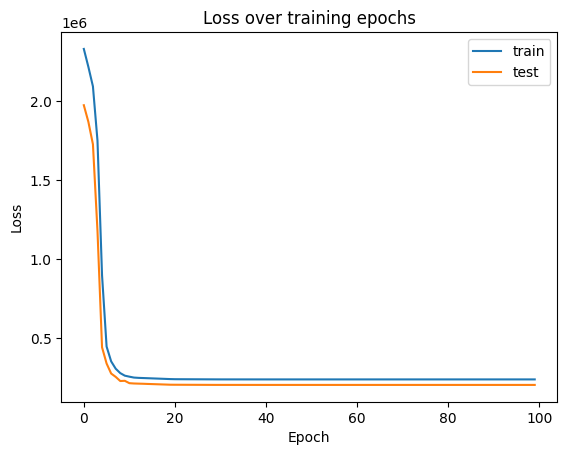

In [16]:
def threshold_plot():
    ax = plt.figure().gca()
    ax.plot(history['train'])
    ax.plot(history['val'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'])
    plt.title('Loss over training epochs')
    plt.show();
    
threshold_plot()


In [5]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum')
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
      result_df = pd.DataFrame({
        'Run_id': range(1, len(predictions) + 1),
        'Loss':losses,
    })
  return result_df , predictions, losses

df_pred ,predictions, losses = predict(model , dataset_tensor)

<Axes: ylabel='Count'>

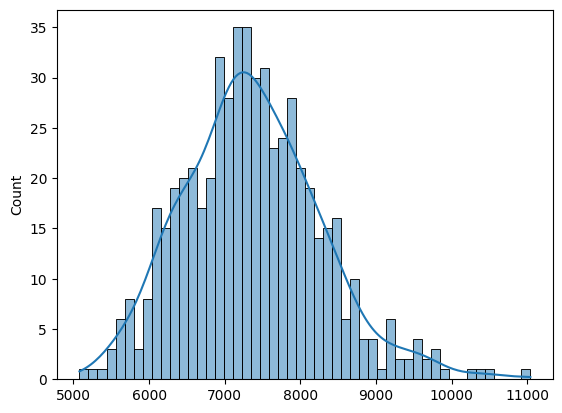

In [7]:
sns.histplot(losses, bins=50, kde=True) 


In [8]:
THRESHOLD = 9000
correct = sum(l <= THRESHOLD for l in losses)
correct

534

In [9]:
anomaly = df_pred[df_pred['Loss'] >= THRESHOLD].index
anomaly_list = list(anomaly)

In [49]:

def append_to_csv(data):
    new_data = pd.DataFrame(data)
    try:
        existing_data = pd.read_csv('anomaly_results.csv')
        if data['model'][0] in existing_data['model'].values:
            existing_data.loc[existing_data['model'] == data['model'][0]] = new_data.values
        else:
            existing_data = pd.concat([existing_data, new_data], ignore_index=True)
    except FileNotFoundError:
        existing_data = new_data
    existing_data.to_csv('anomaly_results.csv', index=False)
    return existing_data

df = append_to_csv(data)
df

,model,anomalies,length,params,hyper_params
0,IsolationForest,"[9, 53, 79, 84, 125, 149, 162, 172, 174, 179, ...",23,"{'n_estimators': 50, 'max_samples': 0.25, 'con...",NaN
1,Autoencoder,"[53, 82, 88, 111, 155, 162, 192, 195, 207, 269...",26,<bound method Module.parameters of Autoencoder...,"{'batch_size': 32, 'n_epochs': 100, 'loss_fn':..."


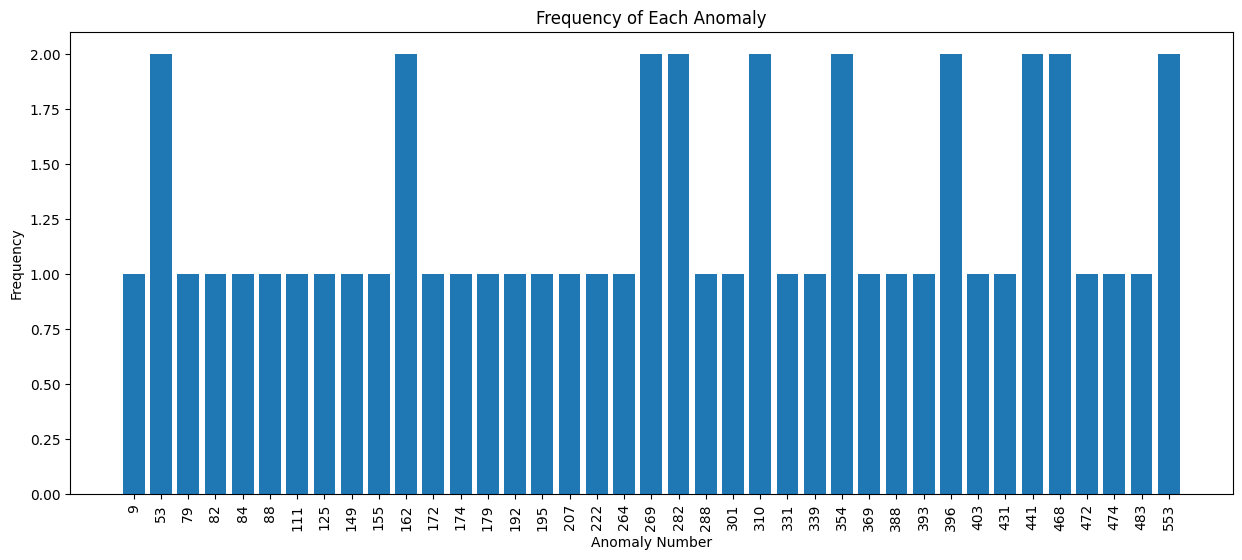

In [63]:
def plot_anomaly_frequency_sorted(df):
    all_anomalies = []
    for item in df['anomalies']:
        if type(item) == str:
            item = [int(num.strip()) for num in item.strip("[]").split(',')]
        all_anomalies += item
    anomaly_counts = Counter(all_anomalies)
    sorted_filtered_counts = dict(sorted(anomaly_counts.items()))
    categories = list(sorted_filtered_counts.keys())
    frequencies = list(sorted_filtered_counts.values())
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar([str(category) for category in categories], frequencies)  # Converting categories to string
    plt.xlabel('Anomaly Number')
    plt.ylabel('Frequency')
    plt.title('Frequency of Each Anomaly')
    plt.xticks(rotation=90) 
    plt.show()

plot_anomaly_frequency_sorted(df)